In [37]:
import os
import random
import glob
from typing import Union, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import pydicom
import torch
from torch import cuda
from torch_radon import ParallelBeam
import cv2

In [24]:
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection'

TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TEST_DATA_PATH=f'{DATASET_PATH}/stage_2_test'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/stage_2_train.csv'
TEST_METADATA_PATH=f'{DATASET_PATH}/stage_2_sample_submission.csv'
PROCESSED_METADATA_DIR_PATH = f'{DATASET_PATH}/processed_metadata'

SEED = 666

In [9]:
#seeding
np.random.seed(SEED)

# Preprocessing

## Metadata preprocessing

In [10]:
class MetadataLoader:
    def __init__(self, train_metadata_path = TRAIN_METADATA_PATH, test_metadata_path = TEST_METADATA_PATH, lazy_load = True):
      self.train_metadata_path = train_metadata_path
      self.test_metadata_path = test_metadata_path
      self._lazy_load = lazy_load
      self._train_df = None
      self._test_df = None
      
      if not self._lazy_load:
        self._load_trainset()
        self._load_testset()
        
    def _read(self, is_read_train_metadata = True):
        csv_file = self.train_metadata_path
        if not is_read_train_metadata:
            csv_file = self.test_metadata_path
            
        df = pd.read_csv(csv_file)
        
        df["Image"] = df["ID"].str.slice(stop=12)
        df["Diagnosis"] = df["ID"].str.slice(start=13)
        
        if is_read_train_metadata:
            duplicates_to_remove = [
                56346, 56347, 56348, 56349,
                56350, 56351, 1171830, 1171831,
                1171832, 1171833, 1171834, 1171835,
                3705312, 3705313, 3705314, 3705315,
                3705316, 3705317, 3842478, 3842479,
                3842480, 3842481, 3842482, 3842483
            ]
            df = df.drop(index=duplicates_to_remove)
            df = df.reset_index(drop=True)
        
        df = df.loc[:, ['Label', 'Diagnosis', 'Image']]
        df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
        
        return df
    
    def sync_with_actual_file(self):
        """
        Some files maybe didn't contain legitimate images, so we need to remove them from dataframe if any
        """
        if self._train_df is None:
            self._load_trainset()
        
        dcms = glob.glob(os.path.join(TRAIN_DATA_PATH, '*.dcm'))
        dcms = [os.path.basename(dcm)[:-4] for dcm in dcms]
        
        self._train_df = self._train_df[self._train_df.index.isin(dcms)]
        

    def _load_trainset(self):
        self._train_df = self._read(is_read_train_metadata=True)
    
    def _load_testset(self):
        self._test_df = self._read(is_read_train_metadata=False)
    
    def reload_set(self):
        self._load_trainset()
        self._load_testset()
    
    @property
    def train_df(self):
        if self._train_df is not None:
            return self._train_df
        self._load_trainset()
        return self._train_df
    
    @property
    def test_df(self):
        if self._test_df is not None:
            return self._test_df
        self._load_testset()
        return self._test_df

In [11]:
def plot_data_distribution(df, legend_suptitle):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle(legend_suptitle)
    sns.countplot(data=df['Label'], x='any', hue='any',  ax=axes[0], palette='Reds')
    axes[0].set_title("Distribution of ICH Diagnoses (Positive vs Negative)")
    axes[0].set_xlabel("ICH Diagnosis (0=Negative, 1=Positive)")
    axes[0].set_ylabel('Count')
    for c in axes[0].containers:
        axes[0].bar_label(c , fmt=lambda x: f'{(x/df["Label"]["any"].count())*100:0.1f}%')

    df_label_counts = df['Label'].sum(axis=0)[1:].reset_index()
    df_label_counts.columns = ['Label', 'Count']
        
    sns.barplot(x='Label', y='Count', data=df_label_counts, hue='Label' , palette='Set2')
    axes[1].set_title('Percentage of Positive Occurrences by ICH Type')
    axes[1].set_xlabel('ICH Type')
    axes[1].set_ylabel('Positive Occurrence (%)')
    plt.setp(axes[1].get_xticklabels(), rotation=45)
    for c in axes[1].containers:
        axes[1].bar_label(c ,fmt=lambda x: f'{x/len(df.index)*100:0.01f}%')

In [12]:
df_loader = MetadataLoader()
df = df_loader.train_df
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_ffff82e46     0        0                0                0            0   
ID_ffff922b9     1        0                0                1            0   
ID_ffffb670a     1        0                0                0            1   
ID_ffffcbff8     0        0                0                0            0   
ID_fffff9393     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0  
...               ...  
ID_ffff82e46        0  
ID_ffff922b9        0  
ID_ffffb670a        0  
ID_ffffcbff8        0  
ID_fffff9393        0  

[752803 rows x 6 columns]

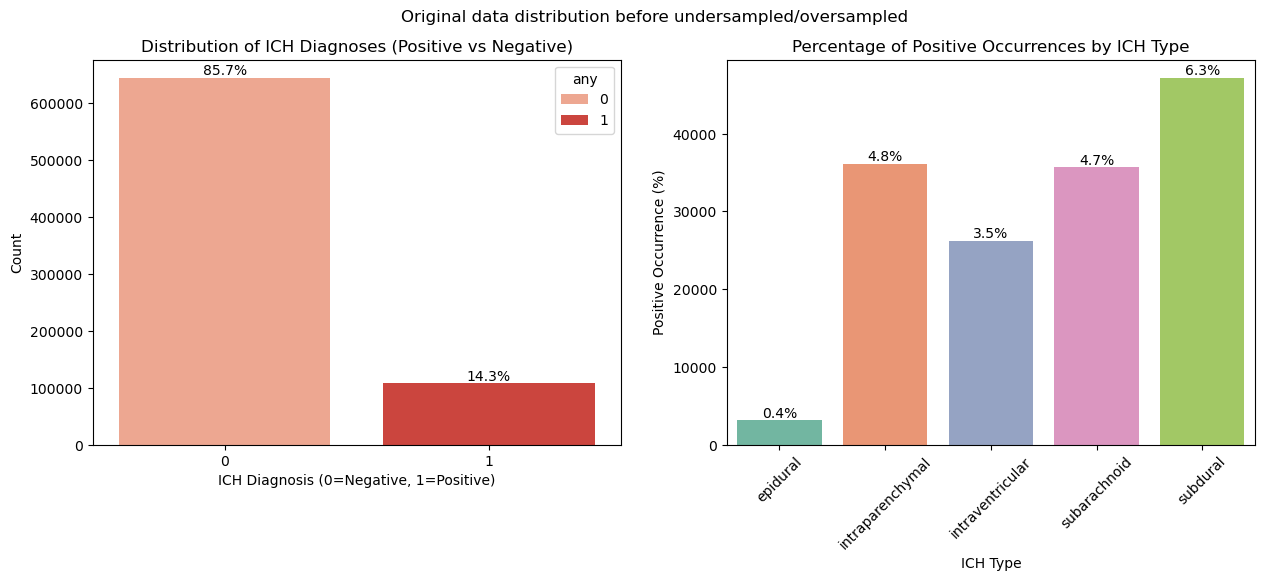

In [13]:
plot_data_distribution(df, 'Original data distribution before undersampled/oversampled')

In [14]:
# oversampling some highly imbalance ich type
epidural_df = df[df['Label']['epidural'] == 1]
oversampled_df = pd.concat([df, epidural_df, epidural_df, epidural_df])
df = oversampled_df

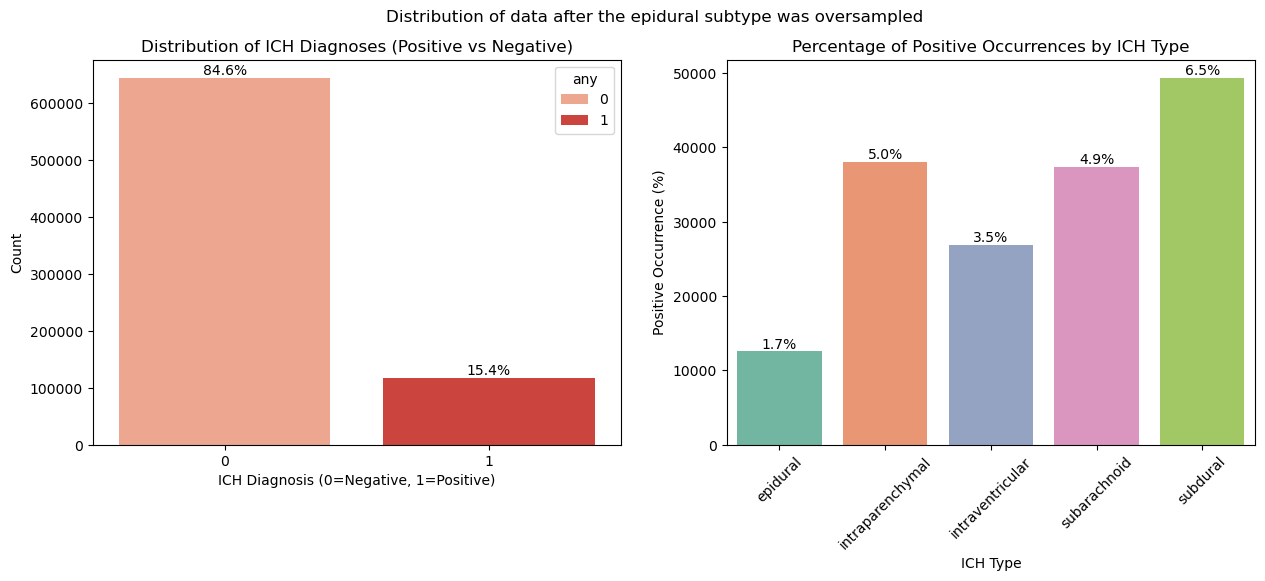

In [15]:
plot_data_distribution(df, 'Distribution of data after the epidural subtype was oversampled')

In [16]:
df['Label']['any'].value_counts()

any
0    644870
1    117368
Name: count, dtype: int64

In [17]:
num_positive_diag = df['Label'][df['Label']['any'] == 1].shape[0]
df_negative_diag_selection = df[df['Label']['any'] == 0].sample(n=int(num_positive_diag*1.25), random_state=42, replace=False)
df_negative_diag_selection

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_1c6bfb61e     0        0                0                0            0   
ID_c59dfca21     0        0                0                0            0   
ID_f339f98d4     0        0                0                0            0   
ID_bfd1b9b9f     0        0                0                0            0   
ID_0c0326411     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_f5e233ae3     0        0                0                0            0   
ID_df9696f51     0        0                0                0            0   
ID_bad097f96     0        0                0                0            0   
ID_ec8584266     0        0                0                0            0   
ID_a3421189a     0        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_1c6bfb61e        0  
ID_c59dfca21        0  
ID_f339f98d4        0  
ID_bfd1b9b9f        0  
ID_0c0326411        0  
...               ...  
ID_f5e233ae3        0  
ID_df9696f51        0  
ID_bad097f96        0  
ID_ec8584266        0  
ID_a3421189a        0  

[146710 rows x 6 columns]

In [18]:
selected_df = df[(df['Label']['any'] == 1) | df.index.isin(df_negative_diag_selection.index.values)]
to_remove_df = df[~df.index.isin(selected_df.index)]

In [19]:
selected_df['Label']['any'].value_counts()

any
0    146710
1    117368
Name: count, dtype: int64

In [20]:
to_remove_df['Label']['any'].value_counts()

any
0    498160
Name: count, dtype: int64

In [26]:
os.makedirs(PROCESSED_METADATA_DIR_PATH, exist_ok=True)
np.save(os.path.join(PROCESSED_METADATA_DIR_PATH, 'indices_to_remove_from_stage_2_train.npy'), arr=to_remove_df.index.values)
del to_remove_df
df = selected_df
df = df.sample(frac=1)

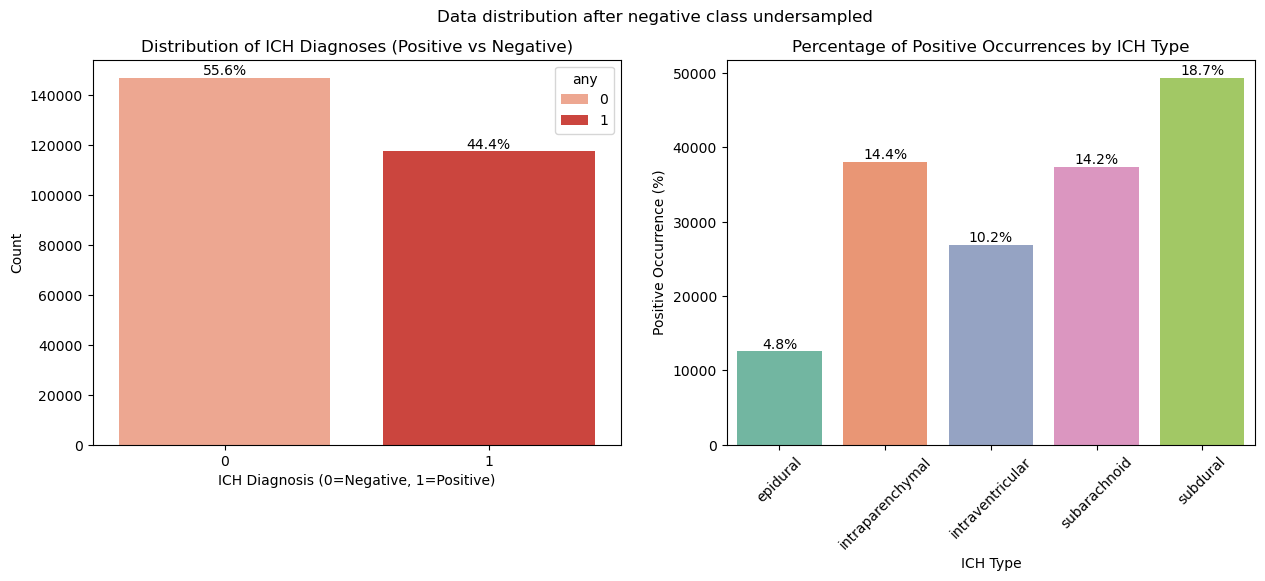

In [27]:
plot_data_distribution(df, 'Data distribution after negative class undersampled')

In [28]:
df.to_pickle(os.path.join(PROCESSED_METADATA_DIR_PATH, 'train_metadata_df.pkl'))

In [29]:
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_99196d0ab     1        0                0                0            0   
ID_2b0190b58     0        0                0                0            0   
ID_056e14224     1        1                0                0            0   
ID_525e72262     0        0                0                0            0   
ID_b00eddf10     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_21e825c20     0        0                0                0            0   
ID_85141c704     1        0                1                0            0   
ID_b4add57dd     0        0                0                0            0   
ID_02f0d7dbb     0        0                0                0            0   
ID_7d29263ce     1        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_99196d0ab        1  
ID_2b0190b58        0  
ID_056e14224        0  
ID_525e72262        0  
ID_b00eddf10        0  
...               ...  
ID_21e825c20        0  
ID_85141c704        1  
ID_b4add57dd        0  
ID_02f0d7dbb        0  
ID_7d29263ce        1  

[264078 rows x 6 columns]

## Dataset preprocessing

### Delete some negative ICH data that has been selected for undersampling to save storage.

In [32]:
img_ids_to_delete = np.load(os.path.join(PROCESSED_METADATA_DIR_PATH, 'indices_to_remove_from_stage_2_train.npy'), allow_pickle=True)

In [35]:
for img_id in tqdm(img_ids_to_delete):
    fpath = os.path.join(TRAIN_DATA_PATH, f'{img_id}.dcm')
    if os.path.exists(fpath):
      os.remove(fpath)
    else:
      print(f'Skipping {fpath}: file not found')

  0%|                                                                               | 0/498160 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 498160/498160 [00:24<00:00, 20684.91it/s]


### Image preparation utilities

In [79]:
def min_max_norm(im):
    range_val = torch.max(im) - torch.min(im)
    if range_val == 0:
        return torch.full_like(im, 0.5)
    return (im - torch.min(im)) / range_val

def std_norm(im):
    std = torch.std(im)
    if std == 0:
        return torch.zero_like(im)
    return (im - torch.mean(im)) / std

def max_abs_norm(im):
    max_abs = torch.max(torch.abs(im))
    if max_abs == 0:
        return torch.zero_like(im)
    return im / torch.max(torch.abs(im))

class ImagePreparationUtil:
    @staticmethod
    def correct_dcm(dcm: pydicom.FileDataset):
        x = dcm.pixel_array
        x = x + 1000
        px_mode = 4096
        x[x >= px_mode] = x[x >= px_mode] - px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000
        
    @staticmethod
    def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int):
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            ImagePreparationUtil.correct_dcm(dcm)
        
        # Pixel to Hounsfield Unit (HU)
        # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
        img = dcm.pixel_array
        img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        
        return img
    
    @staticmethod
    def get_windowed_image(dcm: pydicom.FileDataset, window: Union['brain', 'subdural', 'soft'] = 'brain') -> np.ndarray: # type: ignore
        im = None
        match window:
            case 'brain':
                brain_img = ImagePreparationUtil.window_image(dcm, 40, 80)
                brain_img = (brain_img - 0) / 80
                im = brain_img
            case 'subdural':
                subdural_img = ImagePreparationUtil.window_image(dcm, 80, 200)
                subdural_img = (subdural_img - (-20)) / 200
                im = subdural_img
            case 'soft':
                soft_img = ImagePreparationUtil.window_image(dcm, 40, 380)
                soft_img = (soft_img - (-150)) / 380
                im = soft_img
            case _:
                raise ValueError('invalid window argument')
        
        return im
    
    @staticmethod
    def bsb_window(dcm):
        brain_img = ImagePreparationUtil.get_windowed_image(dcm, window='brain')
        subdural_img = ImagePreparationUtil.get_windowed_image(dcm, window='subdural')
        soft_img = ImagePreparationUtil.get_windowed_image(dcm, window='soft')

        bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

        return bsb_img
    
    @staticmethod
    def bsb_window_sinogram(dcm, radonobj: ParallelBeam):
        brain_img = ImagePreparationUtil.get_windowed_image(dcm, window='brain')
        subdural_img = ImagePreparationUtil.get_windowed_image(dcm, window='subdural')
        soft_img = ImagePreparationUtil.get_windowed_image(dcm, window='soft')
        
        with torch.no_grad():
            brain_img = torch.FloatTensor(brain_img).cuda()
            subdural_img = torch.FloatTensor(subdural_img).cuda()
            soft_img = torch.FloatTensor(soft_img).cuda()

            brain_sino = min_max_norm(radonobj.forward(brain_img)).cpu().numpy()
            subdural_sino = min_max_norm(radonobj.forward(brain_img)).cpu().numpy()
            soft_sino = min_max_norm(radonobj.forward(brain_img)).cpu().numpy()
        
        bsb_sino = np.array([brain_sino, subdural_sino, soft_sino]).transpose(1,2,0)
        return bsb_sino
        
        
    @staticmethod
    def read(path, resize: Tuple[int, int]):
        img = None
        try:
            dcm = pydicom.dcmread(path)
            img = ImagePreparationUtil.bsb_window(dcm)
        except Exception as e:
            print('\nWarning:', e.__class__.__name__, f'for {path} Replacing with zeros image')
            img = np.zeros((*tuple(resize[:2]), 3), dtype=np.float32)
        
        if resize is not None:
            img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_LINEAR)
            
        return img.astype(np.float32)
    
    @staticmethod
    def read_as_sinogram(path, resize: Tuple[int, int], radonobj: ParallelBeam):
        bsb_window = ImagePreparationUtil.read(path, resize)
        bsb_window = bsb_window.transpose(2, 0, 1)
        
        [brain_img, subdural_img, soft_img] = bsb_window
        with torch.no_grad():
            brain_img = torch.FloatTensor(brain_img).cuda()
            subdural_img = torch.FloatTensor(subdural_img).cuda()
            soft_img = torch.FloatTensor(soft_img).cuda()

            brain_sino = min_max_norm(radonobj.forward(brain_img)).cpu().numpy()
            subdural_sino = min_max_norm(radonobj.forward(subdural_img)).cpu().numpy()
            soft_sino = min_max_norm(radonobj.forward(soft_img)).cpu().numpy()
            
        bsb_sino = np.array([brain_sino, subdural_sino, soft_sino]).transpose(1,2,0)
        return bsb_sino

### Extracting Sinogram from 256x256 CT slice image to 300x362 sinogram

In [75]:
IMAGE_SIZE = (256, 256)

In [76]:
theta = torch.linspace(0, np.pi, 360).float().cuda()
radonobj = ParallelBeam(det_count=int(IMAGE_SIZE[0]*np.sqrt(2)), angles=theta)

#### Sanity check

In [80]:
# sanity check
dcm = pydicom.dcmread(os.path.join(TRAIN_DATA_PATH,'ID_9ed70975c.dcm'))

brain_window_img = ImagePreparationUtil.get_windowed_image(dcm, window='brain')
brain_window_img = cv2.resize(brain_window_img, IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

subdural_window_img = ImagePreparationUtil.get_windowed_image(dcm, window='subdural')
subdural_window_img = cv2.resize(subdural_window_img, IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

soft_window_img = ImagePreparationUtil.get_windowed_image(dcm, window='soft')
soft_window_img = cv2.resize(soft_window_img, IMAGE_SIZE, interpolation=cv2.INTER_LINEAR)

bsb_windowed_imgs = [brain_window_img, subdural_window_img, soft_window_img]

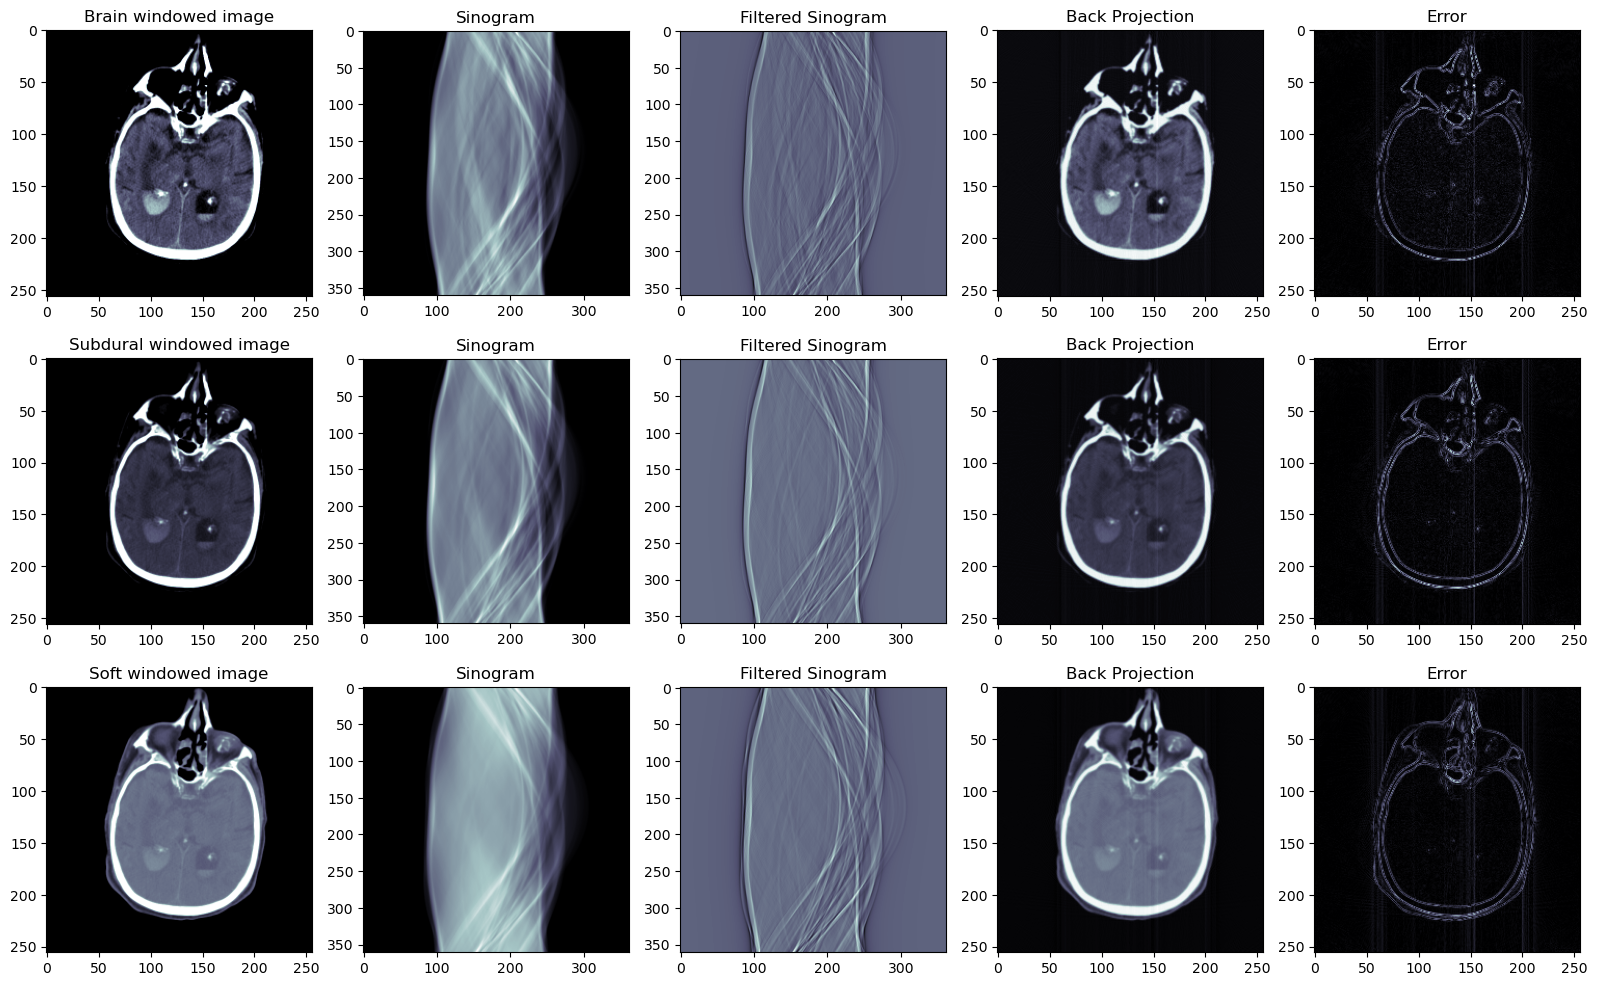

In [81]:
fig, axis = plt.subplots(3, 5, figsize=(16,10))
with torch.no_grad():
    for i, ori_img, w_type in zip(range(len(bsb_windowed_imgs)), bsb_windowed_imgs, ['brain', 'subdural', 'soft']):
        im = torch.FloatTensor(ori_img).cuda()
        sino = radonobj.forward(im)
        filtered_sino = radonobj.filter_sinogram(sino)
        fbp = radonobj.backward(sinogram=filtered_sino, angles=theta)
        axis[i][0].imshow(ori_img, cmap=plt.cm.bone)
        axis[i][0].set_title(f'{w_type} Windowed Image'.capitalize())

        axis[i][1].imshow(sino.cpu().numpy(), cmap=plt.cm.bone)
        axis[i][1].set_title('Sinogram')

        axis[i][2].imshow(filtered_sino.cpu().numpy(), cmap=plt.cm.bone)
        axis[i][2].set_title('Filtered Sinogram')

        axis[i][3].imshow(fbp.cpu().numpy(), cmap=plt.cm.bone)
        axis[i][3].set_title('Back Projection')

        axis[i][4].imshow(torch.abs(im - fbp).cpu().numpy(), cmap=plt.cm.bone)
        axis[i][4].set_title('Error')
    
    plt.tight_layout()
    plt.show()

#### Save sinograms data
stacking them to 3 channel rgb

In [87]:
sinogram_path = os.path.join(DATASET_PATH, 'stage_2_train_sinogram')
os.makedirs(sinogram_path, exist_ok=True)

In [ ]:
for idx, row in tqdm(df.iterrows(), total=len(df.index), desc='Extracting sinogram from dcm dataset'):
    sino = ImagePreparationUtil.read_as_sinogram(os.path.join(TRAIN_DATA_PATH, f'{idx}.dcm'), IMAGE_SIZE, radonobj)
    np.save(os.path.join(sinogram_path, f'{idx}.npy'), arr=sino)